## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.WW

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.
#%%

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from cv import *
from cv_dataset import *
from image_scaler import *
from train_cv import *

In [29]:
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content2views = ContentToViews()

In [31]:
thumbnail_dir = "data/thumbnailUS"

df = pd.read_csv("data/usvideos_rm_dup.csv")
# drop nan in views, do not just use df.dropna()
df = df[df["views"].notna()]

# drop the row if the video_id does not have a thumbnail image
image_set = set()
for file in os.listdir(f"{thumbnail_dir}"):
    image_set.add(file[:-4])
df = df[df["video_id"].isin(image_set)]

dataset = ContentToViewsDataset(thumbnail_dir, df ,cap=-1)

In [32]:
# # demo the dataset
# import matplotlib.pyplot as plt
# # import transforms
# from torchvision import transforms


# image = Image.open("data/thumbnailUS/2kyS6SvSYSE.jpg")
# image
# image_tensor = image_to_vgg(image)

# plt.imshow(image_tensor.permute(1, 2, 0))
# image

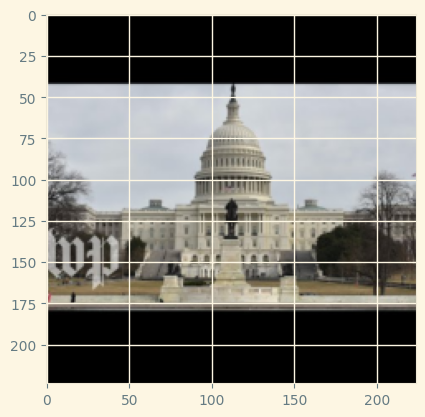

In [33]:
img = dataset[2][0]

plt.imshow(img.permute(1, 2, 0))

In [34]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use("Solarize_Light2")

In [35]:
# split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}")

Train size: 4638


In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True, num_workers=2)

In [37]:
def start_training(model, epochs=10, train_loss_list:list = [], test_loss_list:list=[]):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    train(model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

In [38]:
train_loss_list = []
test_loss_list = []

In [39]:
start_training(content2views, epochs=15, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

Starting Training
Epoch [1|15] finished|116]
Training loss: 14.8898, Test loss: 4.4953, Took: 138.18s, est time: 0:32:14s
Epoch [2|15] finished|116]
Training loss: 4.9293, Test loss: 3.5065, Took: 138.17s, est time: 0:29:56s
Epoch [3|15] finished|116]
Training loss: 4.4640, Test loss: 3.4807, Took: 137.75s, est time: 0:27:32s
Epoch [4|15] finished|116]
Training loss: 3.8129, Test loss: 3.9807, Took: 134.23s, est time: 0:24:36s
Epoch [5|15] finished|116]
Training loss: 3.5242, Test loss: 4.8472, Took: 134.69s, est time: 0:22:26s
Epoch [6|15] finished|116]
Training loss: 2.9203, Test loss: 3.5193, Took: 134.34s, est time: 0:20:09s
Epoch [7|15] finished|116]
Training loss: 2.4762, Test loss: 4.7439, Took: 134.50s, est time: 0:17:55s
Epoch [8|15] finished|116]
Training loss: 2.3090, Test loss: 5.1795, Took: 134.58s, est time: 0:15:42s
Epoch [9|15] finished|116]
Training loss: 2.0793, Test loss: 5.4441, Took: 134.96s, est time: 0:13:29s
Epoch [10|15] finished|116]
Training loss: 2.0364, Tes

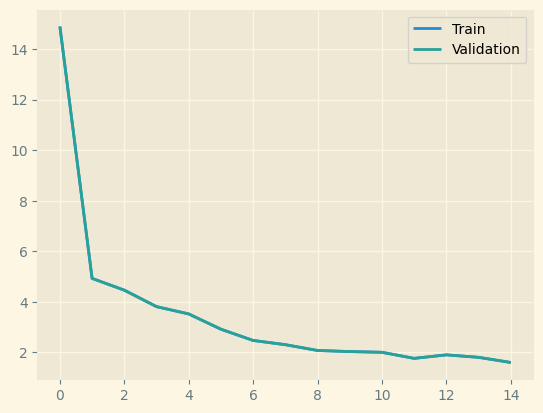

In [47]:

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.legend(["Train", "Validation"])

plt.show()

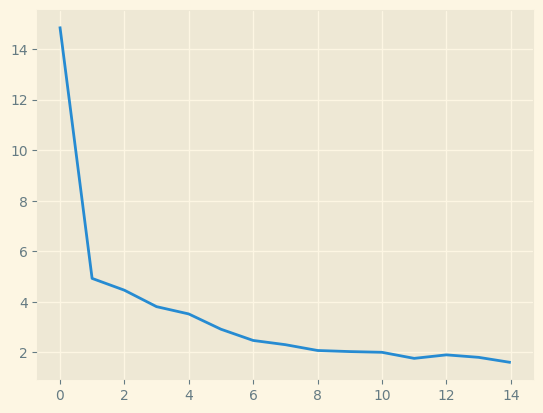

In [44]:
plt.plot(train_loss_list)
plt.show()

In [41]:
best_model = ContentToViews()
best_model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [42]:
images, views = [], []
for i in range(len(test_dataset)):
    image, view = test_dataset[i]
    images.append(image)
    views.append(view)

both = list(zip(images, views))

sorted_both = sorted(both, key=lambda x: x[1])

images, views = zip(*sorted_both)


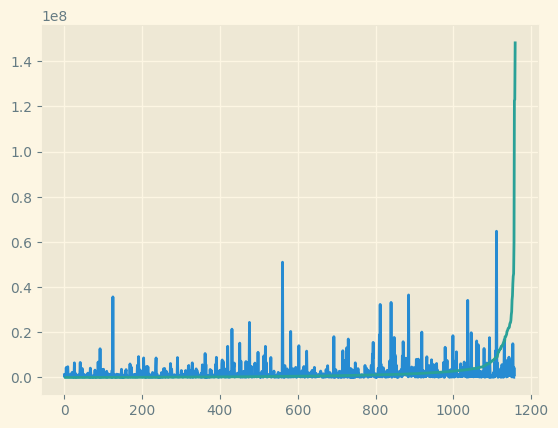

In [43]:
predict_views_counts = []
actual_views_counts = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(len(images)):
    with torch.no_grad():
        best_model.to(device)
        image = images[i].to(device)
        predict_views_log = best_model.forward(image.unsqueeze(0)).cpu()
        predict_views = torch.exp(predict_views_log).item()
        actual_views = torch.exp(views[i]).item()
        predict_views_counts.append(predict_views)
        actual_views_counts.append(actual_views)

plt.plot(predict_views_counts)
plt.plot(actual_views_counts)
plt.show()